In [1]:
# Import visualization dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Import analytical dependencies
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

In [3]:
# Import Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# Choose trip dates
trip_start = '2018-01-01'
trip_end = '2018-01-07'

## Reflect Tables into SQLAlchemy ORM

In [5]:
# Create an engine for the 'hawaii.sqlite' database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
# View all the classes
Base.classes.keys()

['measurement', 'station']

In [10]:
# Create reference variables for each class
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Start a session to query the database
session = Session(engine)

## Exploratory Climate Analysis
---
### Precipitation Analysis

In [12]:
# Retrieve all date values from latest to earliest (descending order)
dates = session.query(Measurement.date).order_by(Measurement.date.desc()).all()
# Create reference variables for the earliest and latest dates
earliest_date = datetime.strptime(dates[-1][0], '%Y-%m-%d')
latest_date = datetime.strptime(dates[0][0], '%Y-%m-%d')
# Create a query to retrieve the last 12 months of precipitation
# Since 2016 is a leap year, add another day to dt.timedelta
last12m_prcp = session.query(Measurement.date,Measurement.prcp).\
                filter(Measurement.date >= latest_date - dt.timedelta(days=366)).\
                order_by(Measurement.date).all()

In [13]:
# Create a Pandas Dataframe and set index to the dates
last12m_prcp_df = pd.DataFrame(last12m_prcp, columns=['date', 'precipitation'])
last12m_prcp_df.set_index('date', inplace=True)

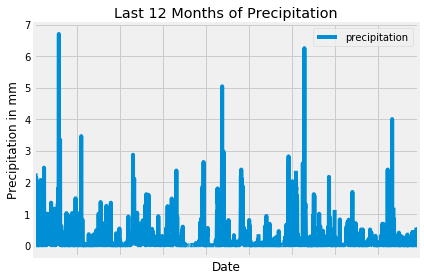

In [14]:
# Use .plot to get a line plot displaying the last 12 months of precipitation data
last12m_prcp_df.plot(title='Last 12 Months of Precipitation')
# Remove ticks on the x-axis for better readability
plt.tick_params(labelbottom=False)  
# Label the x and y-axis appropriately
plt.xlabel('Date')
plt.ylabel('Precipitation in mm')
# Automatically adjust parameter and display the plot
plt.tight_layout()
plt.show()

In [15]:
# Get summary statistics using Pandas
last12m_prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [16]:
# Retrieve the number of stations in the dataset
station_num = session.query(Station.station).group_by(Station.station).count()
print(station_num)

9


In [17]:
# Retrieve the most active stations
active_stations = session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station)\
                  .order_by(func.count(Measurement.tobs).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Create a query to calculate the lowest temperature recorded, highest temperature recorded, 
# and average temperature for the most active station (i.e. USC00519281)
most_active_station_stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),\
                                          func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

most_active_station_stats

[(54.0, 85.0, 71.66378066378067)]

In [19]:
# Retrieve all date values from latest to earliest (descending order) for the most active station (mas)
mas_dates = session.query(Measurement.date).\
                            filter(Measurement.station == 'USC00519281').\
                            order_by(Measurement.date.desc()).all()
# Create reference variables for the latest date for the most active station (mas)
latest_date_mas = datetime.strptime(mas_dates[0][0], '%Y-%m-%d')

# Create a query to retrieve the last 12 months of temperature observation for the most active station
# Since 2016 is a leap year, add another day to dt.timedelta
last12m_tobs = session.query(Measurement.date,Measurement.tobs).\
                filter(Measurement.date >= latest_date_mas - dt.timedelta(days=366)).\
                filter(Measurement.station == 'USC00519281').\
                order_by(Measurement.date).all()
# Create a Pandas Dataframe and set index to the dates
last12m_tobs_df = pd.DataFrame(last12m_tobs, columns=['date', 'tobs'])
last12m_tobs_df.set_index('date', inplace=True)

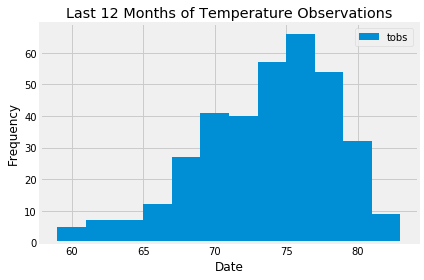

In [20]:
# Use .plot.hist to get a histogram displaying the last 12 months of temperature observation data
last12m_tobs_df.plot.hist(bins=12,title='Last 12 Months of Temperature Observations') 
# Label the x and y-axis appropriately
plt.xlabel('Date')
plt.ylabel('Frequency')
# Automatically adjust parameter and display the plot
plt.tight_layout()
plt.show()

### Temperature Analysis I

In [21]:
# In order to filter by month, import extract from sqlalchemy
from sqlalchemy import extract

# Retrieve all temperature observations values for the month of June, regardless of year
all_temp_in_june = session.query(Measurement.tobs).filter(extract('month', Measurement.date) == 6).all()
# Convert list of tuples into normal list
june_temp_lst = list(np.ravel(all_temp_in_june))
# Identify the average temperature in June
june_avg = session.query(func.avg(Measurement.tobs)).filter(extract('month', Measurement.date) == 6).all()
print(f'The average temperature in the month of June is {june_avg[0][0]} Fahrenheit.')

# Retrieve all temperature observations values for the month of December, regardless of year
all_temp_in_dec = session.query(Measurement.tobs).filter(extract('month', Measurement.date) == 12).all()
# Convert list of tuples into normal list
dec_temp_lst = list(np.ravel(all_temp_in_dec))
# Identify the average temperature in December
dec_avg = session.query(func.avg(Measurement.tobs)).filter(extract('month', Measurement.date) == 12).all()
print(f'The average temperature in the month of December is {dec_avg[0][0]} Fahrenheit.')

The average temperature in the month of June is 74.94411764705882 Fahrenheit.
The average temperature in the month of December is 71.04152933421226 Fahrenheit.


In [22]:
# Import scipy.stats in order to perform unpaired t-tests
import scipy.stats as stats

# Perform a Welch’s t-test
stats.ttest_ind(june_temp_lst, dec_temp_lst, equal_var=False)

Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

Since temperatures in different months are being investigated, the samples are independent groups and therefore, an unpaired t-test was performed. Paired t-tests consist of samples of the same test subjects. In this case, if temperature mean on the same day was being investigated using stations that are in close proximity, then a paired t-test could be used. Because temperatures across two different months are being tested, an unpaired t-test is needed.


Since Seeing as the p-value is very close to zero, with a 95% confidence interval, we can reject the null hypothesis of equal temperature means for June and December.

### Temperature Analysis II

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Obtain the same dates from the previous year
trip_start_prev_yr = datetime.strptime(trip_start,'%Y-%m-%d') - dt.timedelta(days=365)
trip_end_prev_yr = datetime.strptime(trip_end,'%Y-%m-%d') - dt.timedelta(days=365)

# Use 'calc_temps' to calculate the tmin, tavg, and tmax for your trip using the previous year's data for those same dates
vacay_stats_prev_yr = calc_temps(trip_start_prev_yr.date(),trip_end_prev_yr.date())
# Convert list of tuples into normal list
vacay_stats_prev_yr_lst = list(np.ravel(vacay_stats_prev_yr))

print(f"Based on last year's trip dates, the minimum temperature was {vacay_stats_prev_yr_lst[0]} Fahrenheit.")
print(f"Based on last year's trip dates, the average temperature was {round(vacay_stats_prev_yr_lst[1],2)} Fahrenheit.")
print(f"Based on last year's trip dates, the maximum temperature was {vacay_stats_prev_yr_lst[2]} Fahrenheit.")

Based on last year's trip dates, the minimum temperature was 62.0 Fahrenheit.
Based on last year's trip dates, the average temperature was 68.37 Fahrenheit.
Based on last year's trip dates, the maximum temperature was 74.0 Fahrenheit.


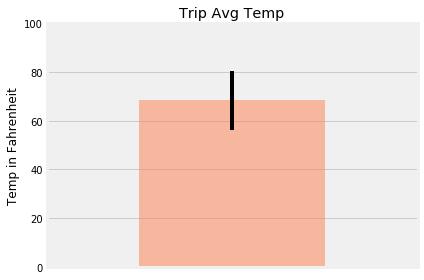

In [26]:
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
peak_to_peak = vacay_stats_prev_yr_lst[2] - vacay_stats_prev_yr_lst[0]
# Create a Pandas Dataframe
vacay_stats_prev_yr_df = pd.DataFrame(vacay_stats_prev_yr, columns=['tmin', 'tavg','tmax'])

# Use .plot.bar to get a bar graph displaying the average temperature for the trip dates from the previous year
vacay_stats_prev_yr_df['tavg'].plot.bar(yerr=peak_to_peak,title='Trip Avg Temp',alpha=0.5,color="coral")
# Remove ticks on the x-axis for better readability
plt.xticks([])
# Adjust y-axis so that it displays temperature from 0 to 100 
plt.yticks(np.arange(0, 105,20))
# Label y-axis appropriately
plt.ylabel("Temp in Fahrenheit")
# Automatically adjust parameter and display the plot
plt.tight_layout()
plt.show()

### Daily Normals

In [27]:
# Calculate total rainfall per weather station using trip dates from the previous year
session.query(Station.station,Station.name,Station.latitude,Station.longitude, \
              Station.elevation,func.sum(Measurement.prcp)).\
              join(Measurement,Station.station==Measurement.station).\
              filter(Measurement.date >= trip_start_prev_yr).\
              filter(Measurement.date <= trip_end_prev_yr).\
              group_by(Station.station,Station.name).\
              order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.61),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.6),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.57),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.16999999999999998),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.06),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)]

In [28]:
# This function 'daily_normals' will calculate daily normals for a specific date 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# Test the function    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [29]:
# Create datetime variables for trip start and end dates
start = datetime.strptime(trip_start, "%Y-%m-%d")
end = datetime.strptime(trip_end, "%Y-%m-%d")
# Use list comprehension to create a trip_range
trip_range = [start + dt.timedelta(days=day) for day in range(0, (end-start).days + 1)]
# Use list comprehension with strftime to remove the year
trip_dates = [datetime.strftime(trip_range[day],'%m-%d') for day in range(0,len(trip_range))]

# Use list comprehension to perform the daily_normals function
normals = [daily_normals(date)[0] for date in trip_dates]
print(normals)

[(62.0, 69.15384615384616, 77.0), (60.0, 69.39622641509433, 77.0), (62.0, 68.9090909090909, 77.0), (58.0, 70.0, 76.0), (56.0, 67.96428571428571, 76.0), (61.0, 68.96491228070175, 76.0), (57.0, 68.54385964912281, 76.0)]


In [30]:
# Create Pandas DataFrame using normals and add the 'trip_dates' range as the index
normals_df = pd.DataFrame(normals, index= trip_dates,columns=['tmin', 'tavg','tmax'])
normals_df

,tmin,tavg,tmax
01-01,62.0,69.153846,77.0
01-02,60.0,69.396226,77.0
01-03,62.0,68.909091,77.0
01-04,58.0,70.000000,76.0
01-05,56.0,67.964286,76.0
01-06,61.0,68.964912,76.0
01-07,57.0,68.543860,76.0


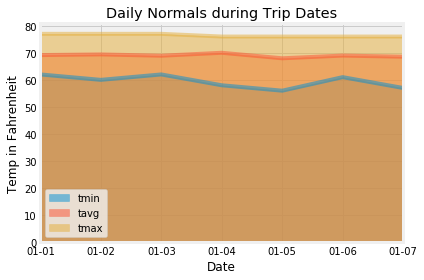

In [31]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False,alpha=0.5, title = "Daily Normals during Trip Dates")
# Label x-axis and y-axis appropriately
plt.xlabel("Date")
plt.ylabel("Temp in Fahrenheit")
# Automatically adjust parameter and display the plot
plt.tight_layout()
plt.show()